In [1]:
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [2]:
N = 1e4
p = 0.075  # 0.1

G = nx.barabasi_albert_graph(N,  30, seed=1234)
# G = nx.erdos_renyi_graph(N, p, seed=1234)
nit = 500

# G = jack.graph_tools(G)
# jack.graph_plots(G)
k = G.degree()
G.degree_list = [d for n, d in k]
G.k_avg = np.mean(G.degree_list)

print(G.k_avg)

59.82


In [3]:
model = ep.SIRModel(G)

beta = 0.0025  # infection rate
gamma = 0.1  # recovery rate
init = 5e-3  # initial infected population

print(model.parameters)
print(model.available_statuses)

config = mc.Configuration()
config.add_model_parameter('beta',  beta)
config.add_model_parameter('gamma', gamma)
config.add_model_parameter("percentage_infected", init)

model.set_initial_status(config)

{'model': {'beta': {'descr': 'Infection rate', 'range': [0, 1], 'optional': False}, 'gamma': {'descr': 'Recovery rate', 'range': [0, 1], 'optional': False}, 'tp_rate': {'descr': 'Whether if the infection rate depends on the number of infected neighbors', 'range': [0, 1], 'optional': True, 'default': 1}}, 'nodes': {}, 'edges': {}}
{'Susceptible': 0, 'Infected': 1, 'Removed': 2}


In [4]:
iterations = model.iteration_bunch(nit, node_status=True)
trends = model.build_trends(iterations)

100%|██████████| 500/500 [00:13<00:00, 36.95it/s]


In [5]:
S = np.array([S for S, I, R in
              [list(it['node_count'].values()) for it in iterations]])
Ii = np.array([I for S, I, R in
              [list(it['node_count'].values()) for it in iterations]])

D = int(1/gamma)
Ro = beta * D * G.k_avg
Rt = Ro * S/N

# smoothing in funzione di D per togliere il rumore stocastico
Ir = pd.Series(list(Ii)).rolling(window=D).mean().iloc[D-1:].values

# a posteriori
K = np.diff(np.log(Ir/N))
R = np.exp(K * D)

print(Ro)

1.4955


<ipython-input-5-ec1d3bc42234>:14: RuntimeWarning: divide by zero encountered in log
  K = np.diff(np.log(Ir/N))
/home/giacomo/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


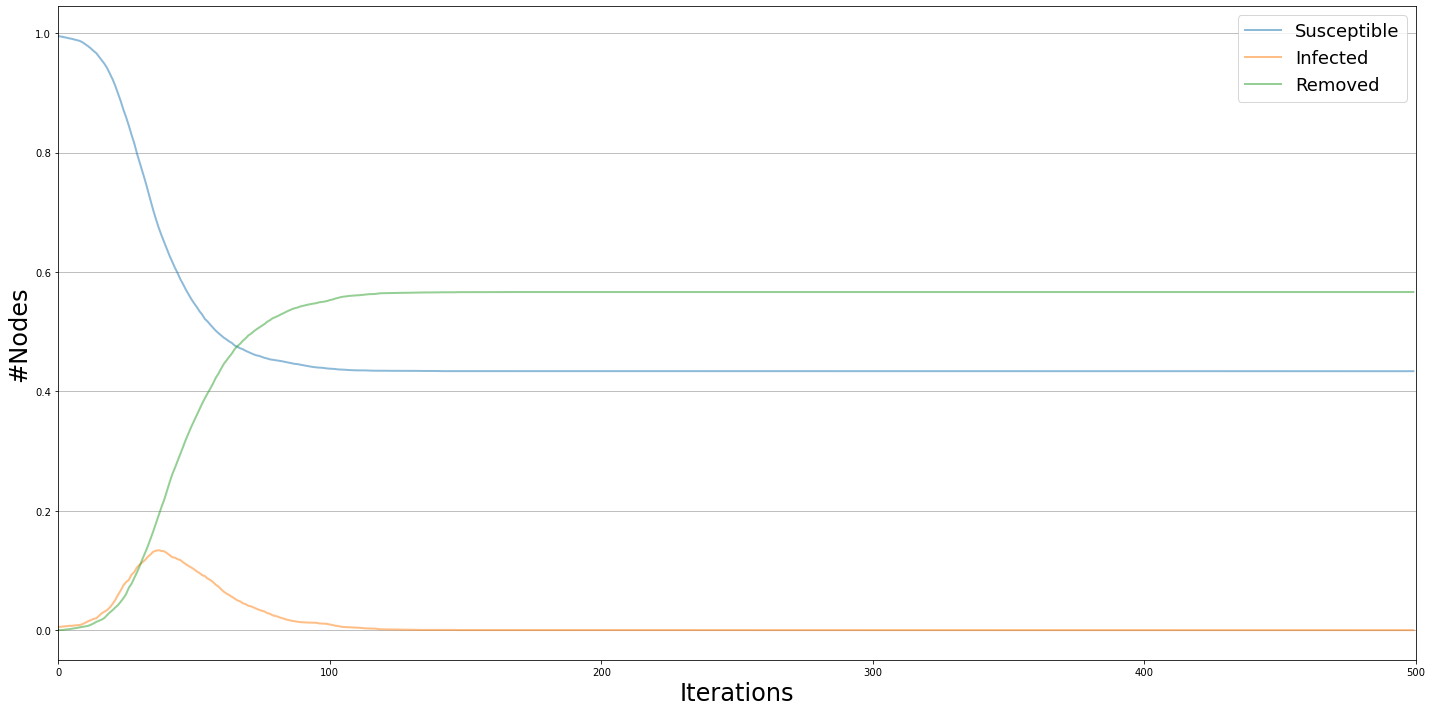

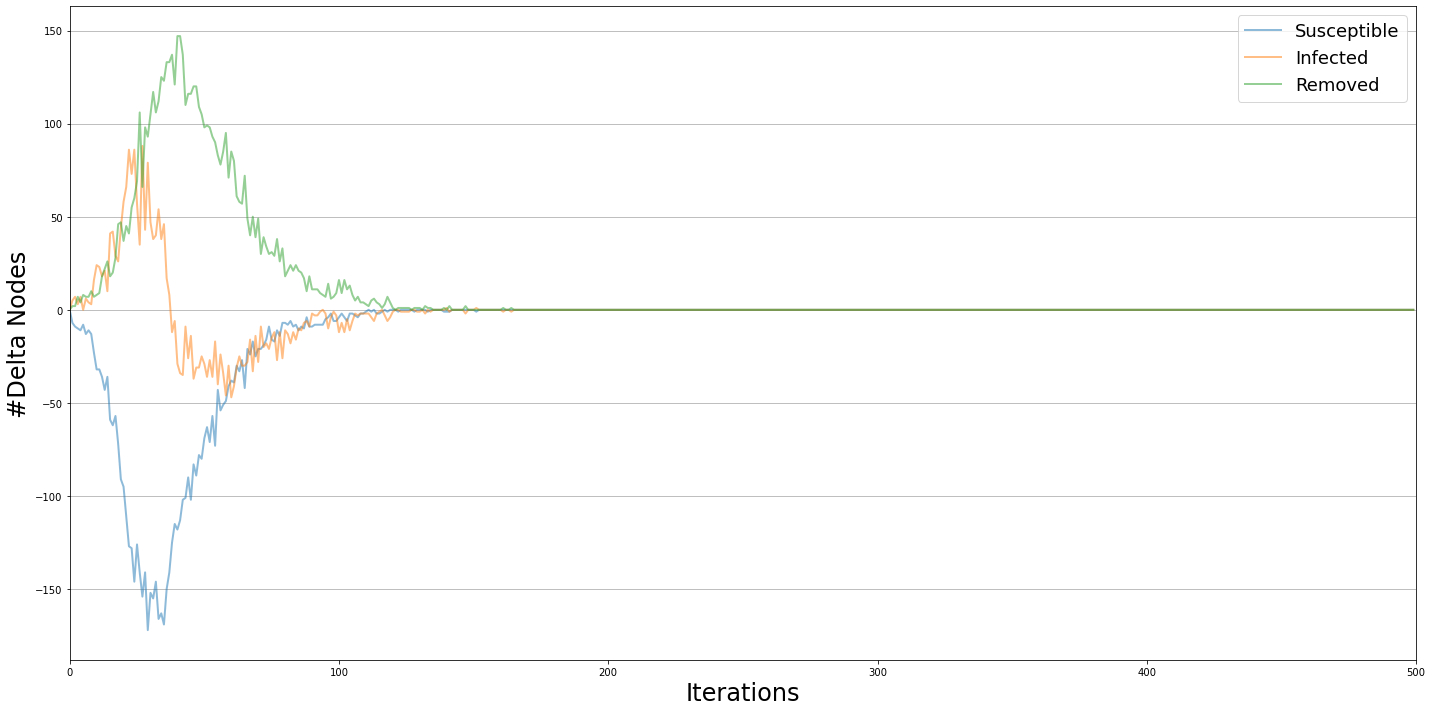

In [6]:
viz = DiffusionTrend(model, trends)
viz.plot()


viz = DiffusionPrevalence(model, trends)
viz.plot()

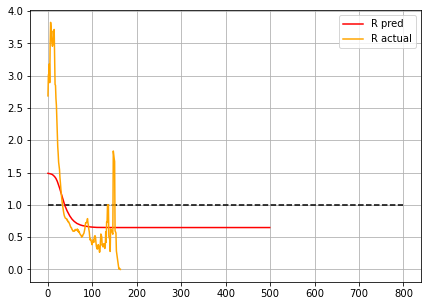

In [7]:
figR = plt.figure()
plt.plot([1 for i in range(800)], 'k--')
plt.plot(Rt, 'r', label='R pred')
plt.plot(R, 'orange', label='R actual')
plt.legend(loc='best')
plt.grid()